### Imports

In [70]:
import numpy as np, pandas as pd
import joblib, os
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("ticks")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
%load_ext autoreload
%autoreload 2
from scripts import farseeing, classifiers, utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Uncertainty-Aware Fall Detection
The test set is not segmented. `X_test` is the full 20-minute signal and `y_test` contains the fall points for each signal.

#### With 5-fold Cross-validation and Multiphase

In [71]:
# Tabular models
kwargs = dict(
	window_size=7, cv=5,
	segment_test=False,
	multiphase=True,
	model_type='tabular'
)
tab_metric_df, tab_aggr_df = classifiers.cross_validate(
	farseeing, **kwargs)
tab_metric_df['model_type'] = 'tabular'
tab_aggr_df['model_type'] = 'tabular'



-- fold 1, testing on (8 subjects) --
Train set: X: (2638, 700), y: (2638,) ([ADLs, Falls]) [2524  114]
Test set: X: 34, y: 34
⏳ TRAINING LogisticCV. RandomForest. ExtraTrees. ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. Ensemble. ✅


-- fold 2, testing on (8 subjects) --
Train set: X: (1659, 700), y: (1659,) ([ADLs, Falls]) [1587   72]
Test set: X: 46, y: 46
⏳ TRAINING LogisticCV. RandomForest. ExtraTrees. ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. Ensemble. ✅


-- fold 3, testing on (8 subjects) --
Train set: X: (1352, 700), y: (1352,) ([ADLs, Falls]) [1291   61]
Test set: X: 17, y: 17
⏳ TRAINING LogisticCV. RandomForest. ExtraTrees. ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. Ensemble. ✅


-- fold 4, testing on (8 subjects) --
Train set: X: (1136, 700), y: (1136,) ([ADLs, Falls]) [1091   45]
Test set: X: 18, y: 18
⏳ TRAINING LogisticCV. RandomForest. ExtraTrees. ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. Ensemble. ✅


-- fold 5, testing on (8 subjects) --


In [72]:
# ts models
kwargs['model_type']='ts'
ts_metric_df, ts_aggr_df = classifiers.cross_validate(
	farseeing, **kwargs)
ts_metric_df['model_type'] = 'ts'
ts_aggr_df['model_type'] = 'ts'



-- fold 1, testing on (8 subjects) --
Train set: X: (2638, 700), y: (2638,) ([ADLs, Falls]) [2524  114]
Test set: X: 34, y: 34
⏳ TRAINING Rocket. Catch22. QUANT. ✅
🔍 TESTING Rocket. Catch22. QUANT. Ensemble. ✅


-- fold 2, testing on (8 subjects) --
Train set: X: (1659, 700), y: (1659,) ([ADLs, Falls]) [1587   72]
Test set: X: 46, y: 46
⏳ TRAINING Rocket. Catch22. QUANT. ✅
🔍 TESTING Rocket. Catch22. QUANT. Ensemble. ✅


-- fold 3, testing on (8 subjects) --
Train set: X: (1352, 700), y: (1352,) ([ADLs, Falls]) [1291   61]
Test set: X: 17, y: 17
⏳ TRAINING Rocket. Catch22. QUANT. ✅
🔍 TESTING Rocket. Catch22. QUANT. Ensemble. ✅


-- fold 4, testing on (8 subjects) --
Train set: X: (1136, 700), y: (1136,) ([ADLs, Falls]) [1091   45]
Test set: X: 18, y: 18
⏳ TRAINING Rocket. Catch22. QUANT. ✅
🔍 TESTING Rocket. Catch22. QUANT. Ensemble. ✅


-- fold 5, testing on (8 subjects) --
Train set: X: (815, 700), y: (815,) ([ADLs, Falls]) [790  25]
Test set: X: 29, y: 29
⏳ TRAINING Rocket. Catch22.

In [73]:
# save all dfs
all_metric_df = pd.concat([tab_metric_df, ts_metric_df], ignore_index=True)
all_aggr_df = pd.concat([tab_aggr_df, ts_aggr_df], ignore_index=True)
all_metric_df.to_csv('results/farseeing_all_metric_df_7.csv', index=False)
all_aggr_df.to_csv('results/farseeing_all_aggr_df_7.csv', index=False)

In [74]:
load_path = 'results/farseeing_all_metric_df_7.csv'
all_metric_df = pd.read_csv(load_path)
tab_metric_df = all_metric_df[all_metric_df['model_type'] == 'tabular']
ts_metric_df = all_metric_df[all_metric_df['model_type'] == 'ts']

In [75]:
tab_metric_df.replace({'model': {'Ensemble': 'Tabular Ensemble'}}, inplace=True)
ts_metric_df.replace({'model': {'Ensemble': 'TS Ensemble'}}, inplace=True)
all_metric_df = pd.concat([tab_metric_df, ts_metric_df], ignore_index=True)

/tmp/ipykernel_493225/1827662966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tab_metric_df.replace({'model': {'Ensemble': 'Tabular Ensemble'}}, inplace=True)
/tmp/ipykernel_493225/1827662966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_metric_df.replace({'model': {'Ensemble': 'TS Ensemble'}}, inplace=True)


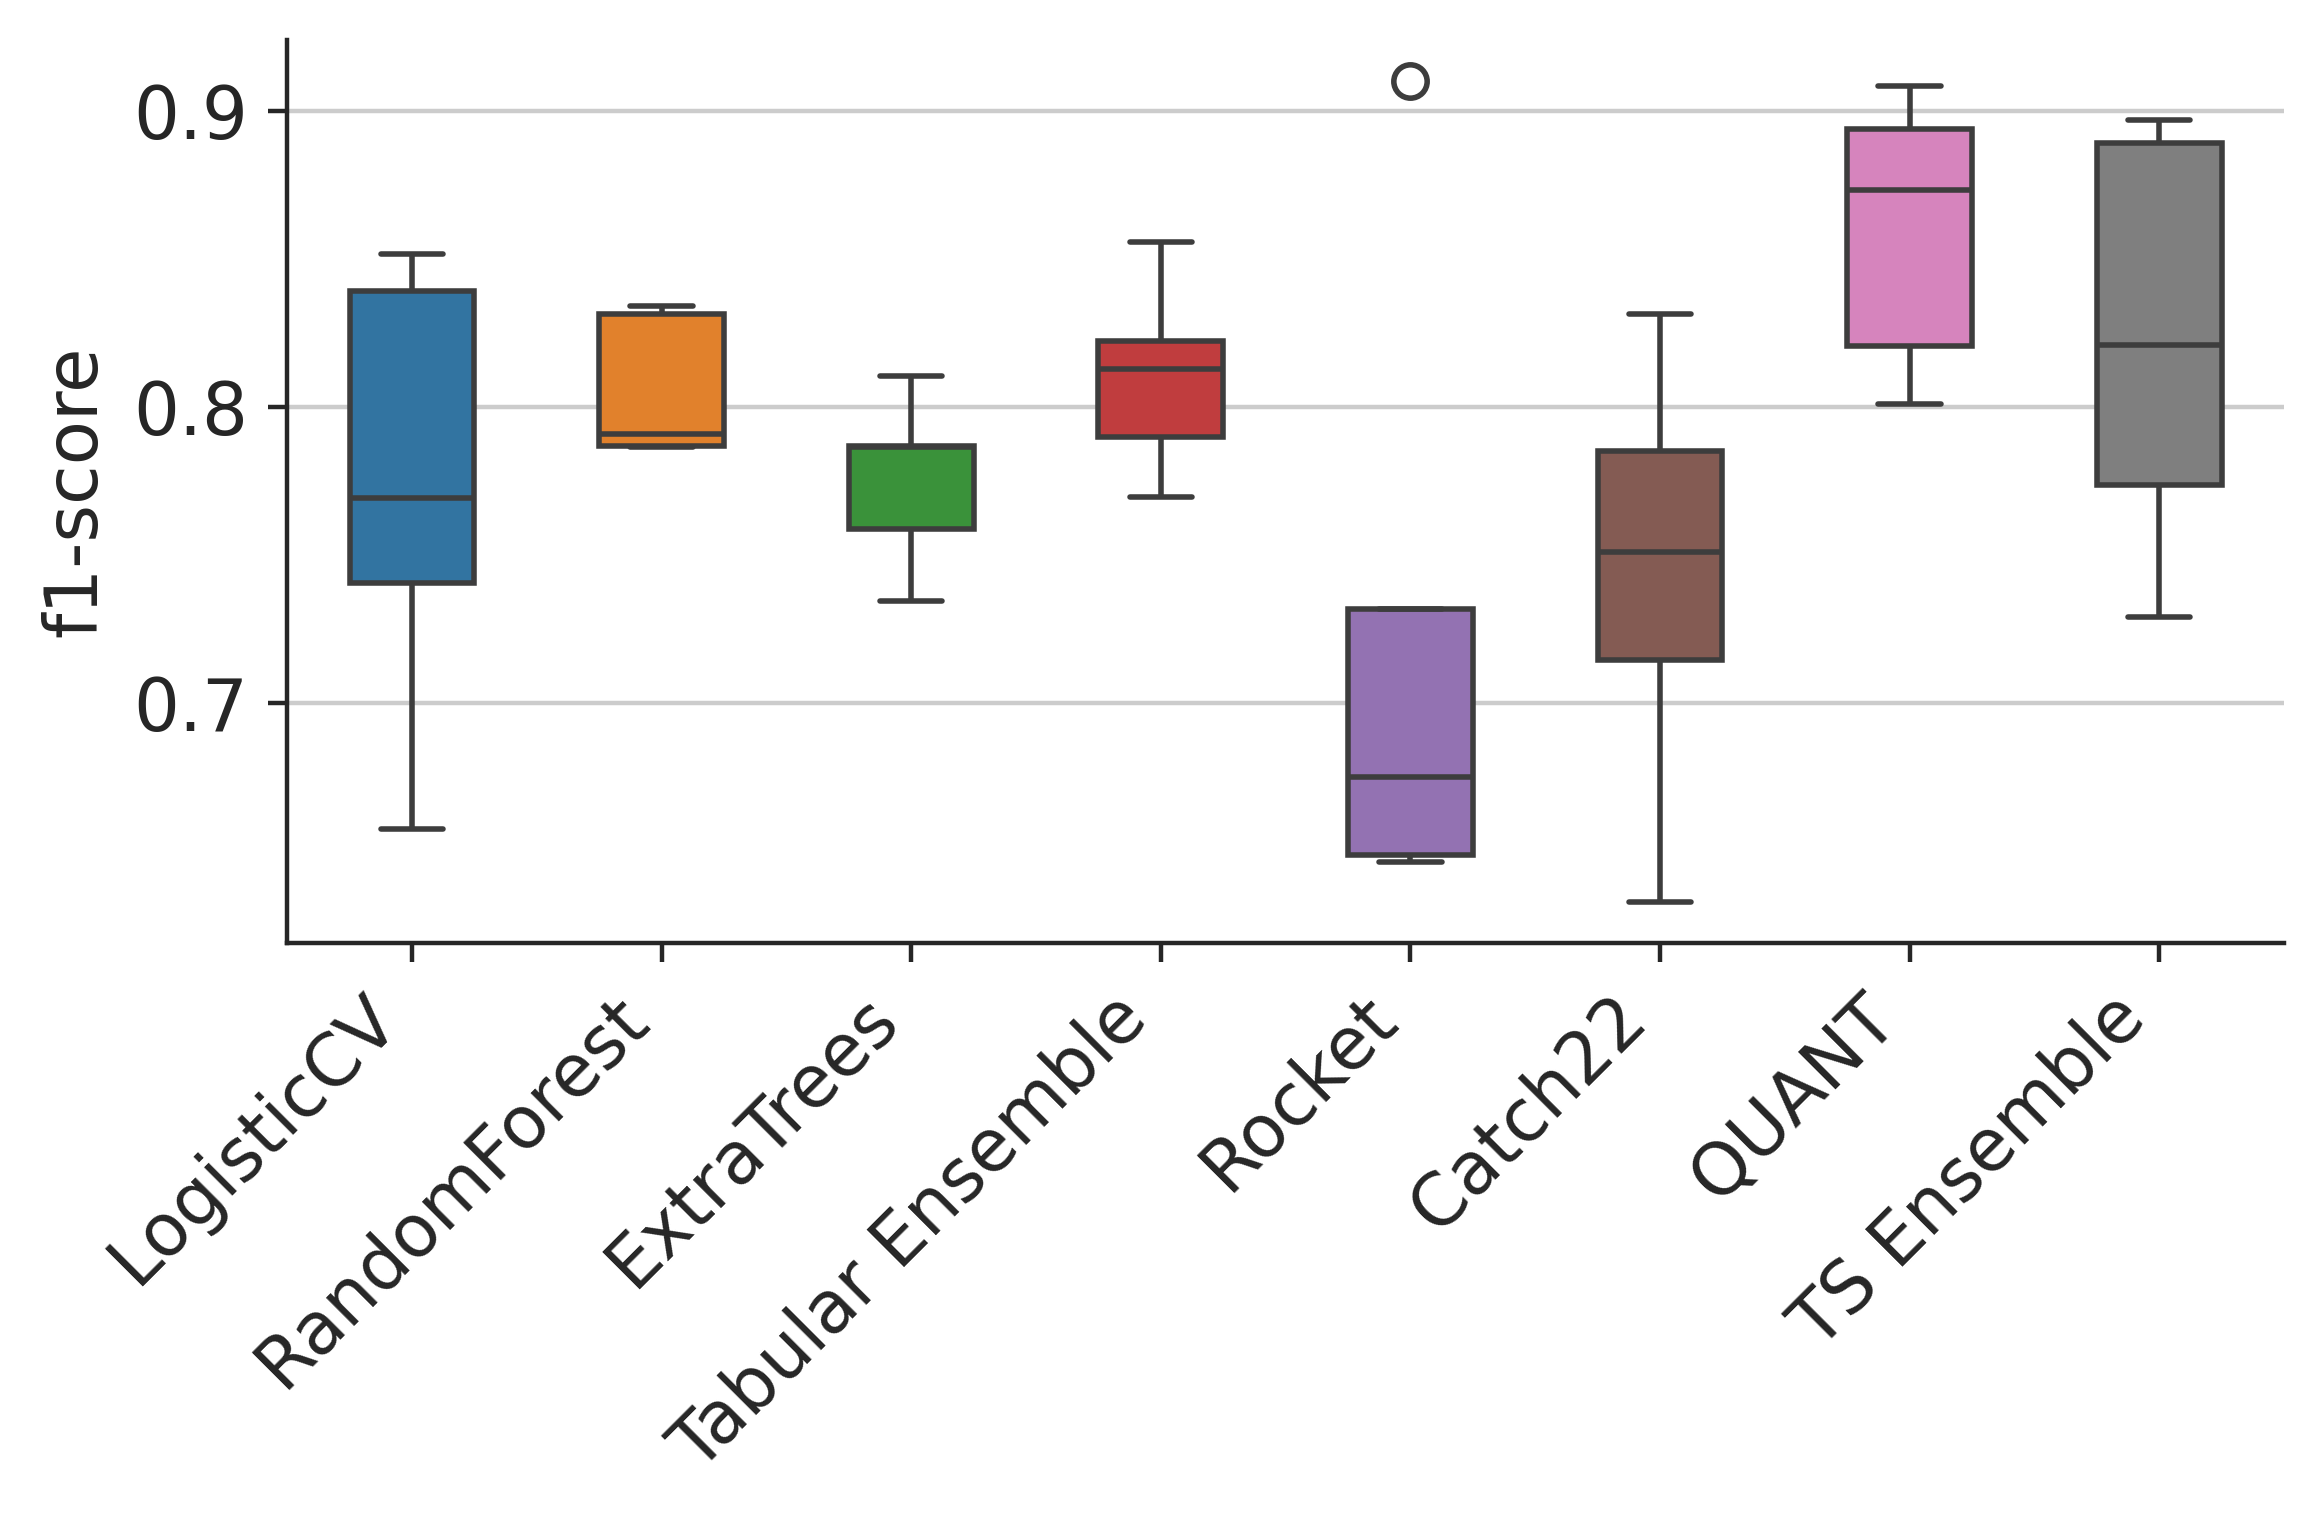

In [76]:
utils.summary_visualization([all_metric_df], name='all_models')

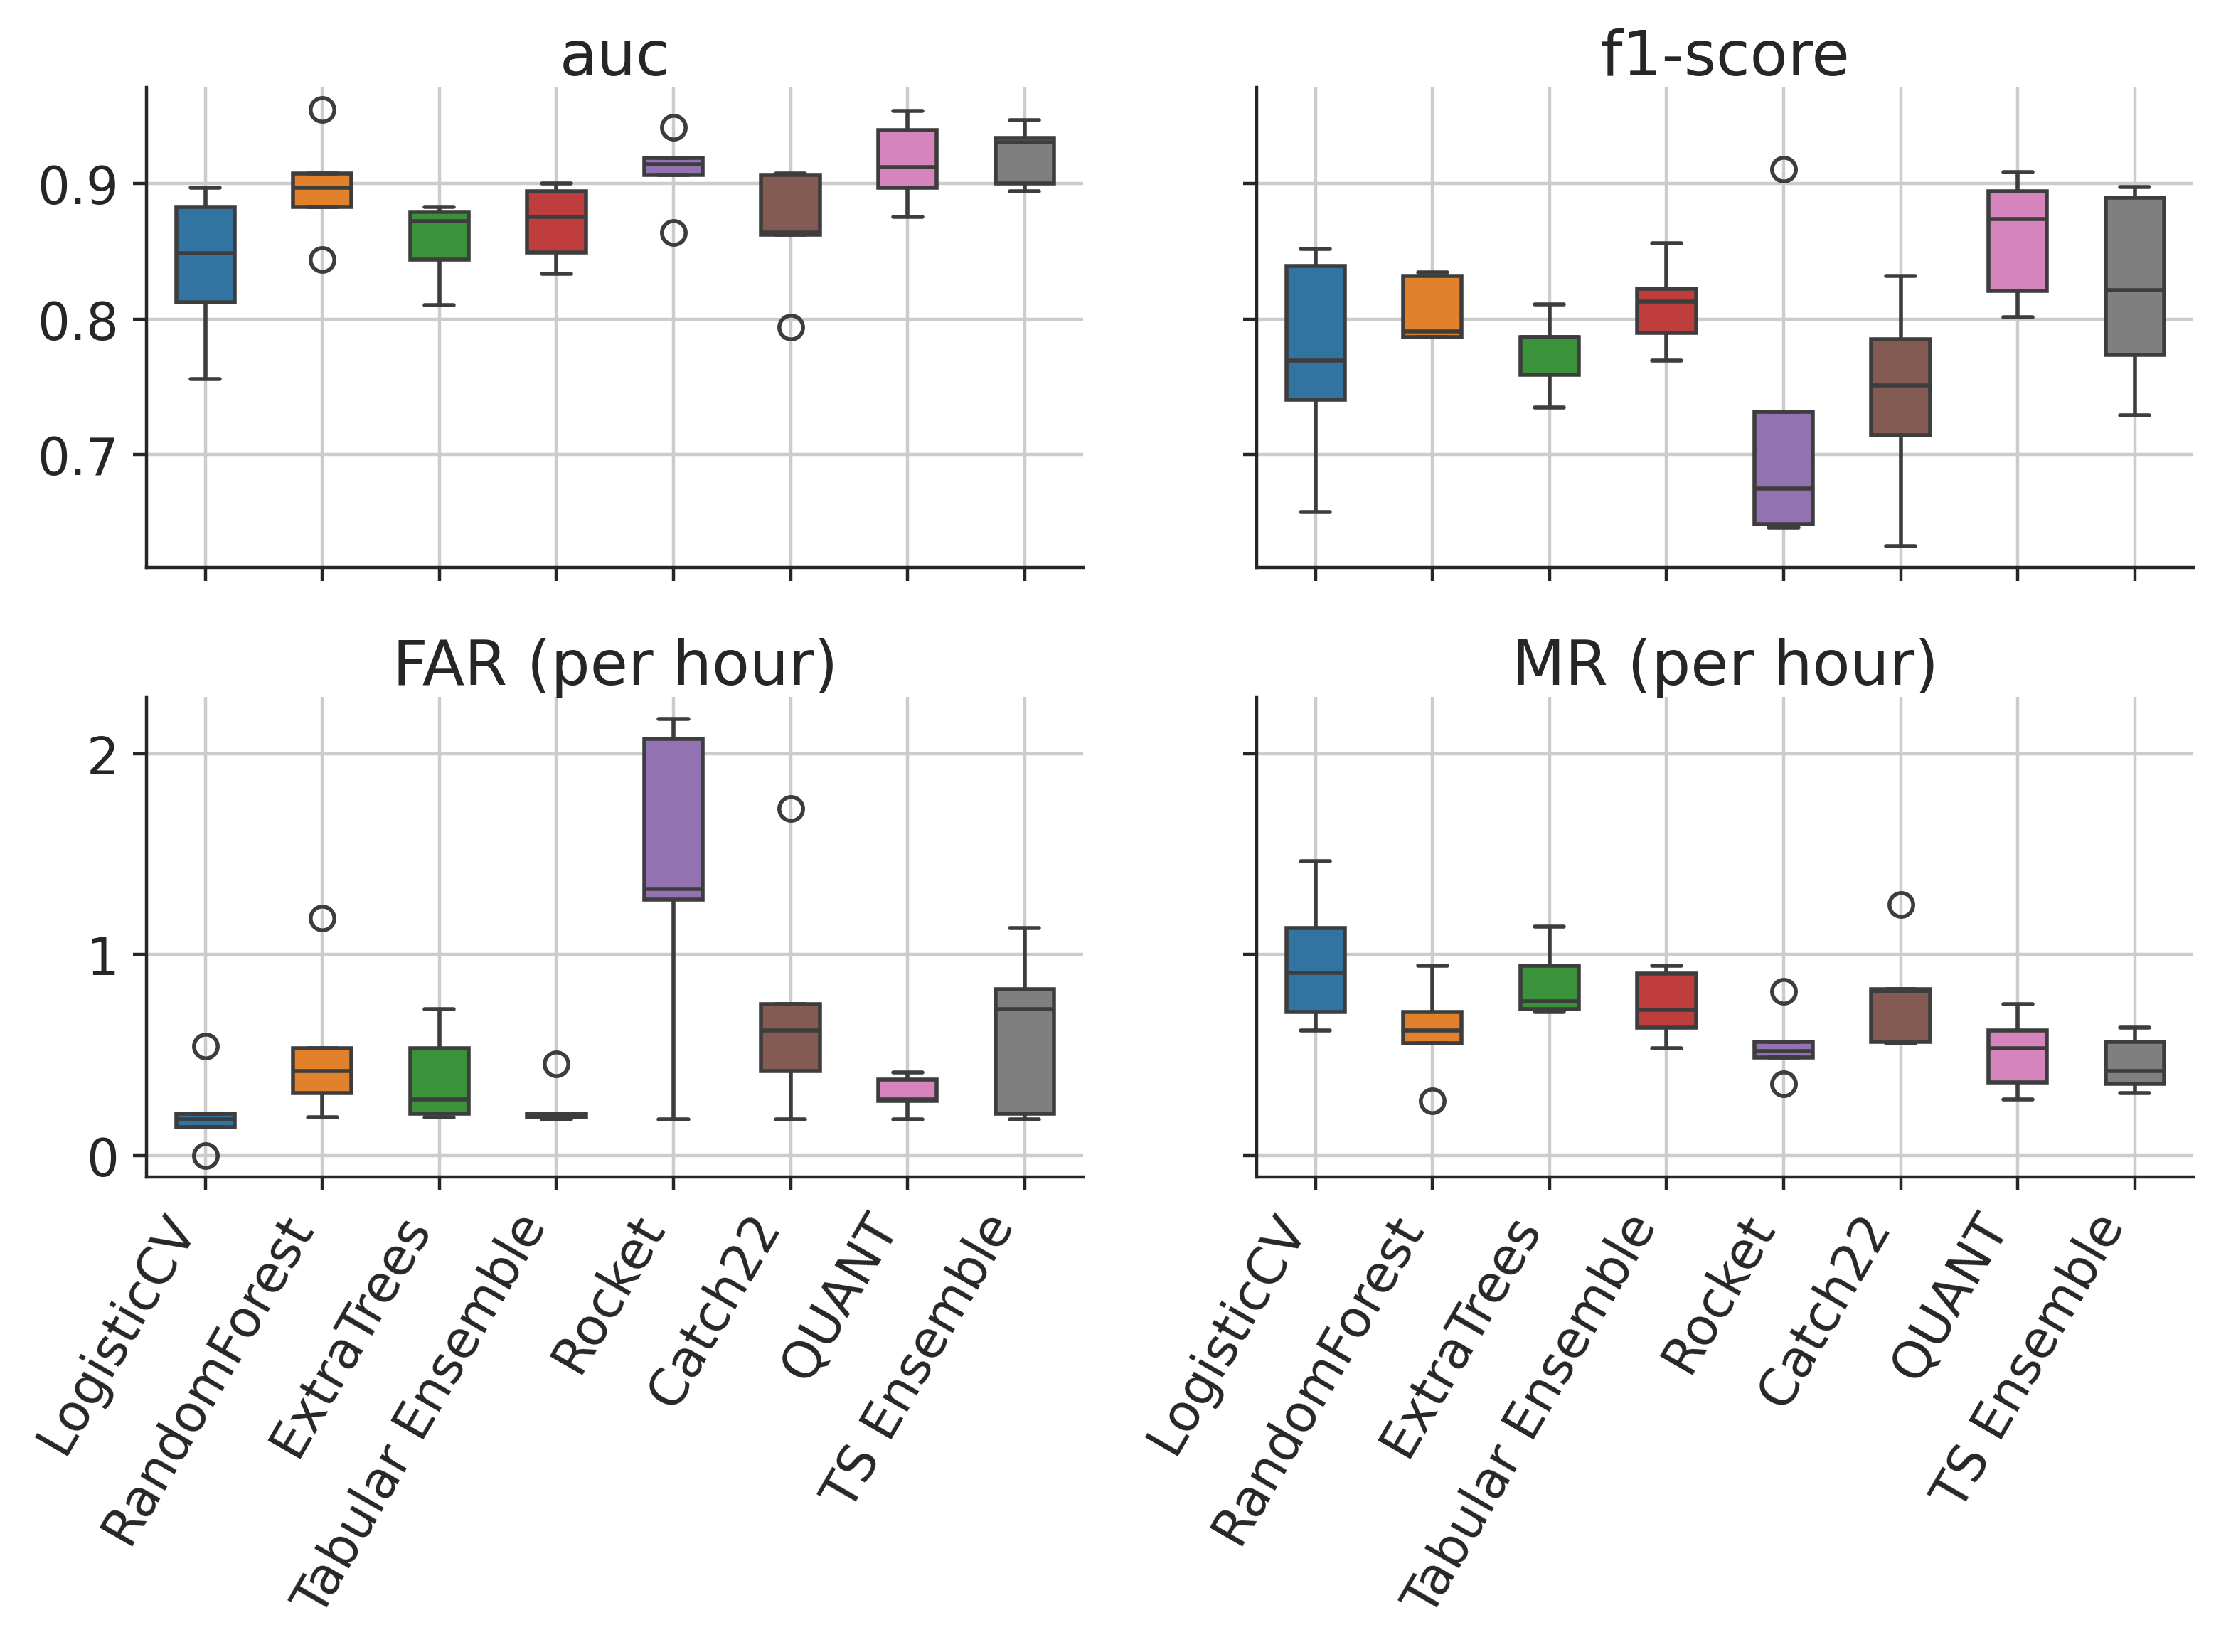

In [77]:
metrics = ['auc', 'f1-score',
           'false alarm rate', 'miss rate']
utils.visualise_all_metrics(all_metric_df, metrics=metrics)

#### Cost-sensitive

In [78]:
kwargs = dict(
	window_size=7,
    multiphase=True,
	segment_test=False,
	tune_threshold=True)
dataset = utils.train_test_subjects_split(
    farseeing, **kwargs)

Train set: X: (3426, 700), y: (3426,)        ([ADLs, Falls]) [3314  112]
Test set: X: 34, y: 34


In [79]:
metrics_df = []
kwargs['ensemble'] = False
kwargs['models_subset'] = None
for t in [False, True]:
    kwargs['tune_threshold'] = t
    for model_type in ['tabular', 'ts']:
        kwargs['model_type'] = model_type
        df = classifiers.run_models(*dataset, **kwargs)
        df['threshold'] = 'auto' if t else 'default'
        df['model_type'] = model_type
        metrics_df.append(df)
metrics_df = pd.concat(metrics_df, ignore_index=True)
metrics_df.to_csv('results/farseeing_tune_threshold_7.csv', index=False)

⏳ TRAINING LogisticCV. RandomForest. ExtraTrees. ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. . ✅
⏳ TRAINING Rocket. Catch22. QUANT. ✅
🔍 TESTING Rocket. Catch22. QUANT. . ✅
⏳ TRAINING LogisticCV. Tuning threshold...
thresh: 0.23232391950197182 RandomForest. Tuning threshold...
thresh: 0.4972390572390572 ExtraTrees. Tuning threshold...
thresh: 0.4747474747474748 ✅
🔍 TESTING LogisticCV. RandomForest. ExtraTrees. . ✅
⏳ TRAINING Rocket. Tuning threshold...
thresh: 0.010101010101010102 Catch22. Tuning threshold...
thresh: 0.4605050505050505 QUANT. Tuning threshold...
thresh: 0.3535353535353536 ✅
🔍 TESTING Rocket. Catch22. QUANT. . ✅


In [80]:
metrics_df.sort_values(by=['model'])

,model,window_size,runtime,auc,precision,recall,specificity,f1-score,false alarm rate,miss rate,delay,g,threshold,model_type
4,Catch22,7,17.075863,0.863636,0.89,0.727273,0.999999,0.800450,0.272725,0.818175,4.736970,0.001,default,ts
10,Catch22,7,16.825943,0.878787,0.86,0.757576,0.999999,0.805545,0.363633,0.727267,3.949091,0.001,auto,ts
2,ExtraTrees,7,0.667503,0.939394,0.94,0.878788,0.999999,0.908364,0.181817,0.363633,1.909091,0.001,default,tabular
8,ExtraTrees,7,0.483499,0.954545,0.94,0.909091,0.999999,0.924287,0.181817,0.272725,1.272727,0.001,auto,tabular
0,LogisticCV,7,0.106666,0.878787,0.83,0.757576,0.999999,0.792136,0.454542,0.727267,3.969697,0.001,default,tabular
6,LogisticCV,7,0.137397,0.954544,0.77,0.909091,0.999998,0.833785,0.818175,0.272725,-0.606061,0.001,auto,tabular
5,QUANT,7,4.424086,0.954545,0.88,0.909091,0.999999,0.894309,0.363633,0.272725,0.878788,0.001,default,ts
11,QUANT,7,12.400659,0.984848,0.84,0.969697,0.999998,0.900201,0.545450,0.090908,-0.475152,0.001,auto,ts
1,RandomForest,7,0.170963,0.954544,0.79,0.909091,0.999998,0.845372,0.727267,0.272725,1.282424,0.001,default,tabular
7,RandomForest,7,0.170978,0.954544,0.79,0.909091,0.999998,0.845372,0.727267,0.272725,1.282424,0.001,auto,tabular


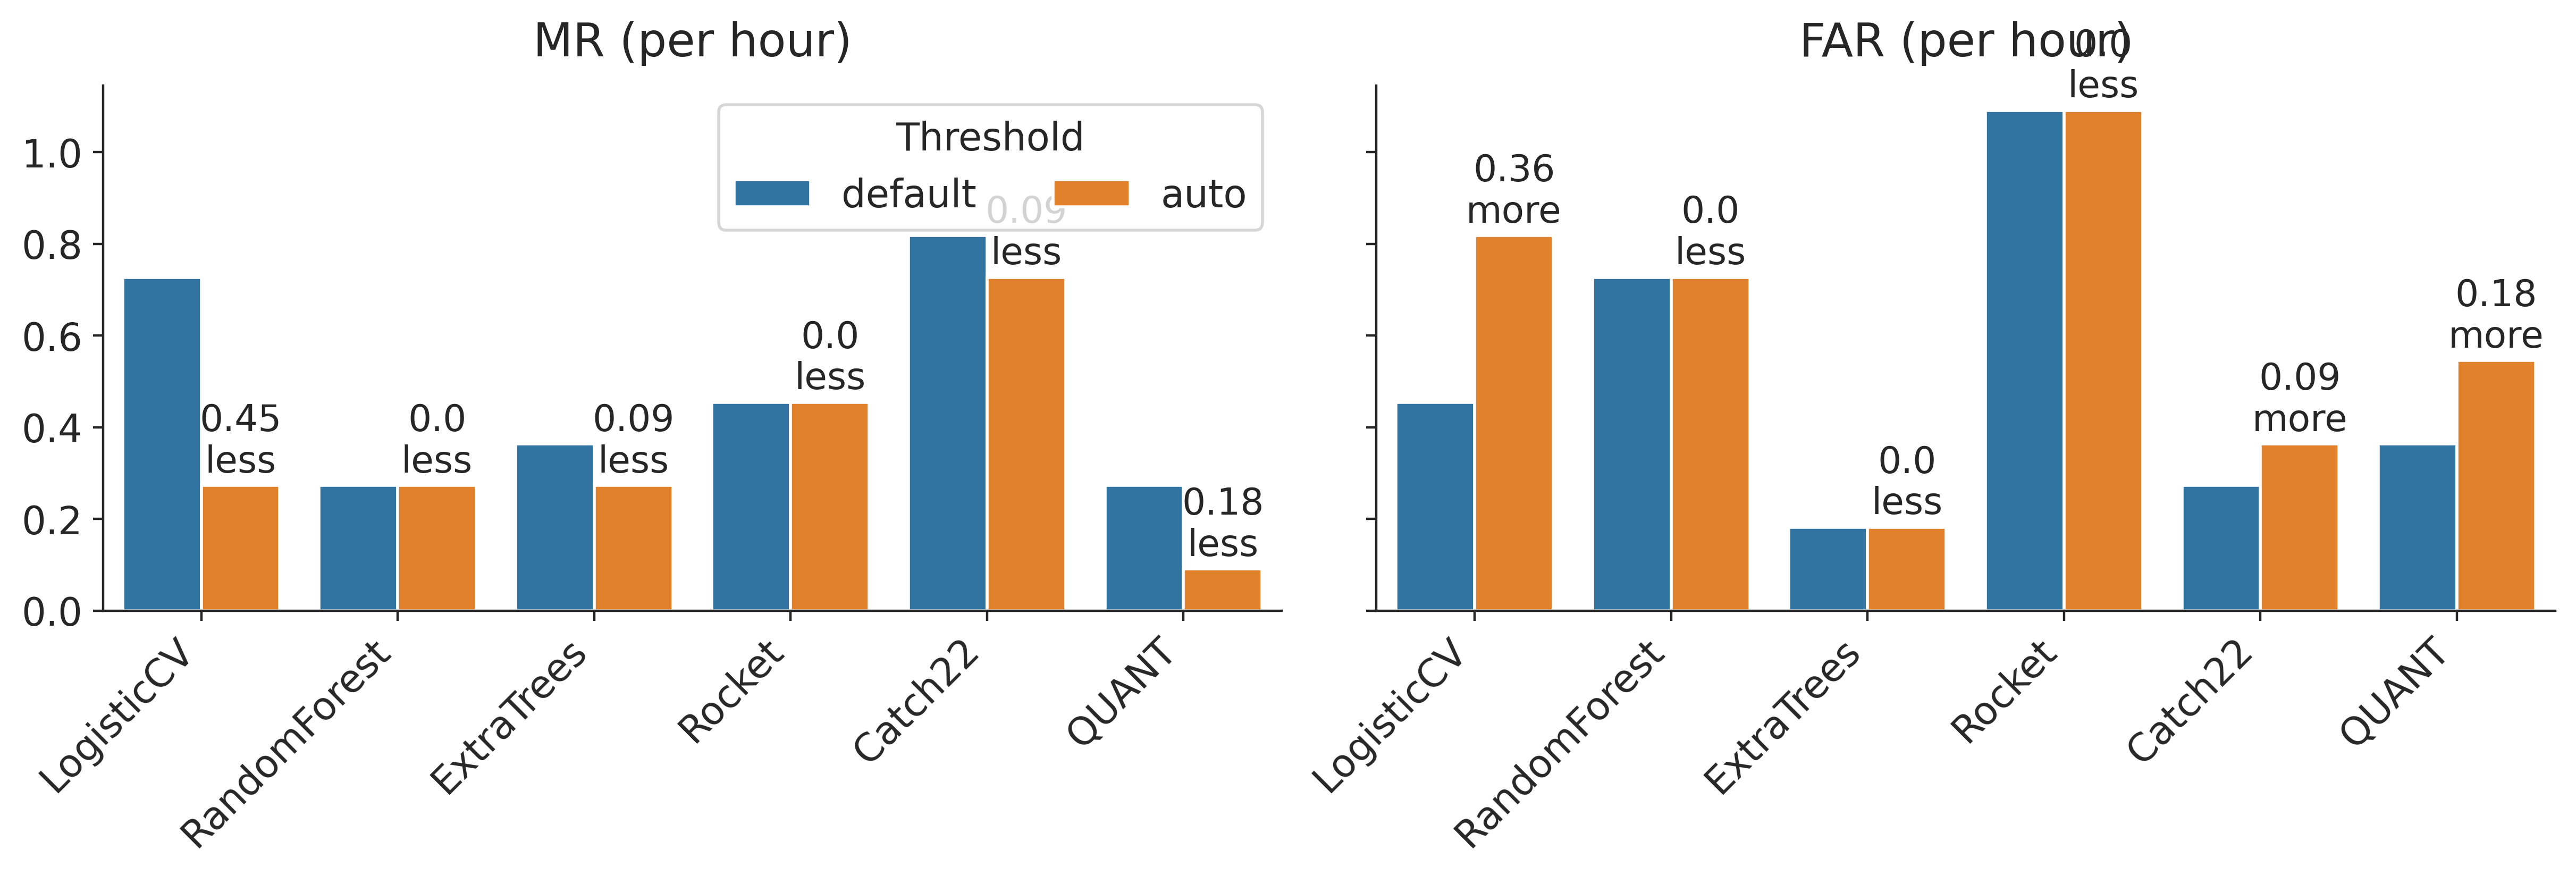

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=400,
					   sharey=True, layout='constrained')
for i, m in enumerate(['miss rate', 'false alarm rate']):
	sns.barplot(data=metrics_df, x='model', y=m, hue='threshold',
			 ax=ax[i], palette='tab10')
	labels1 = [x for x in ax[i].containers[0].datavalues] # Round up container[0] values
	labels2 = [x for x in ax[i].containers[1].datavalues] # Round up container[1] values
	improvements = [np.round(b-a,2) for a, b in zip(labels1, labels2)] # Calculate improvements
	lbls = [f'{i}\nmore' if i > 0 else f'{abs(i)}\nless' for i in improvements] # Annotate using rounded values
	# Annotate using rounded values
	ax[i].bar_label(ax[i].containers[1], labels=lbls, fontsize=12.5, padding=2)
	ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')
	m = 'FAR (per hour)' if m == 'false alarm rate' else m
	m = 'MR (per hour)' if m == 'miss rate' else m
	ax[i].set_title(m, pad=10)
	ax[i].set_xlabel('')
	ax[i].set_ylabel('')
	# only show legend for the last plot
	if i > 0:
		ax[i].get_legend().remove()
	else:
		ax[i].legend(title='Threshold', ncols=2)
sns.despine()
plt.savefig('figs/barplot_tune_threshold_7sec.pdf',
			dpi=400, bbox_inches='tight')
plt.show()

#### Cost sensitivity analysis

In [28]:
kwargs['ensemble'] = False
kwargs['models_subset'] = ['QUANT']
kwargs['tune_threshold'] = False
dataset = utils.train_test_subjects_split(farseeing, **kwargs)
X_train, X_test, y_train, y_test = dataset
trained_quant, thresh = classifiers.train_models(X_train, y_train, **kwargs)

Train set: X: (3426, 700), y: (3426,)        ([ADLs, Falls]) [3314  112]
Test set: X: 34, y: 34
⏳ TRAINING QUANT. ✅


In [33]:
# save the trained models

joblib.dump({'models': trained_quant,
             'thresholds': thresh},
             'models/farseeing_trained_quant_7.joblib')

['models/farseeing_trained_quant_7.joblib']

### Tolerance Analysis

In [37]:
kwargs['saved_models'] = 'models/farseeing_trained_quant_7.joblib'
kwargs['ensemble'] = False
tune_df = []
tolerances = np.arange(0, 300, 20)
for t in tolerances:
	print(f'Testing at tolerance of {t} secs')
	kwargs['tolerance'] = t
	df = classifiers.run_models(*dataset, **kwargs)
	df['tolerance'] = t
	tune_df.append(df)
tune_df = pd.concat(tune_df, ignore_index=True)
tune_df.to_csv('results/quant_tolerance_analysis.csv', index=False)

Testing at tolerance of 0 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 20 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 40 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 60 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 80 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 100 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 120 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 140 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 160 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 180 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 200 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 220 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 240 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 260 secs
Loaded models
🔍 TESTING QUANT. . ✅
Testing at tolerance of 280 secs
Loaded models
🔍 TESTI

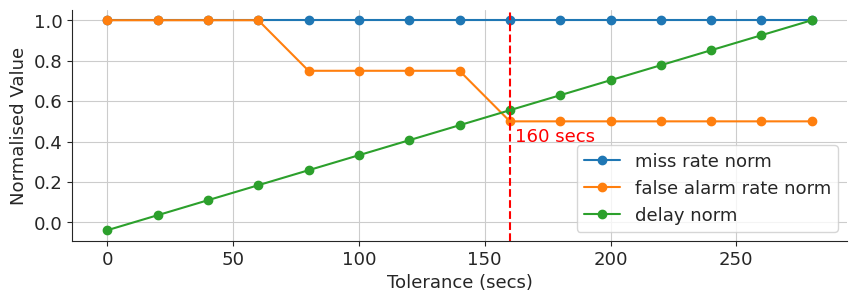

In [62]:
# normalise miss rate, false alarm rate and delay
tune_df['miss rate norm'] = tune_df['miss rate'] / tune_df['miss rate'].max()
tune_df['false alarm rate norm'] = tune_df['false alarm rate'] / tune_df['false alarm rate'].max()
tune_df['delay norm'] = tune_df['delay'] / tune_df['delay'].max()
tune_df.plot(x='tolerance', y=['miss rate norm', 'false alarm rate norm', 'delay norm'],
					  kind='line', marker='o', figsize=(10, 3), grid=True)
# draw a vertical line and annotate where miss rate norm == delay norm
intersection = tune_df.loc[tune_df['false alarm rate norm'].sub(tune_df['delay norm']).abs().idxmin()]['tolerance']
plt.axvline(intersection, color='r', linestyle='--')
plt.annotate(f'{intersection} secs',
			 (intersection+2, 0.4), color='r')
plt.xlabel('Tolerance (secs)')
plt.ylabel('Normalised Value')
plt.legend()
sns.despine()
plt.savefig('figs/tolerance_analysis.pdf', dpi=400, bbox_inches='tight')
plt.show()

In [64]:
kwargs['saved_models'] = None
kwargs['ensemble'] = False
window_df = []
winsizes = np.arange(3, 60)
for w in winsizes:
	print(f'Testing at window_size of {w} secs')
	kwargs['window_size'] = w
	dataset = utils.train_test_subjects_split(farseeing, **kwargs)
	df = classifiers.run_models(*dataset, **kwargs)
	window_df.append(df)
window_df = pd.concat(window_df, ignore_index=True)
window_df.to_csv('results/quant_window_analysis.csv', index=False)

Testing at window_size of 3 secs
Train set: X: (3524, 300), y: (3524,)        ([ADLs, Falls]) [3412  112]
Test set: X: 34, y: 34
⏳ TRAINING QUANT. ✅
🔍 TESTING QUANT. . ✅
Testing at window_size of 4 secs
Train set: X: (3488, 400), y: (3488,)        ([ADLs, Falls]) [3376  112]
Test set: X: 34, y: 34
⏳ TRAINING QUANT. ✅
🔍 TESTING QUANT. . ✅
Testing at window_size of 5 secs
Train set: X: (3461, 500), y: (3461,)        ([ADLs, Falls]) [3349  112]
Test set: X: 34, y: 34
⏳ TRAINING QUANT. ✅
🔍 TESTING QUANT. . ✅
Testing at window_size of 6 secs
Train set: X: (3444, 600), y: (3444,)        ([ADLs, Falls]) [3332  112]
Test set: X: 34, y: 34
⏳ TRAINING QUANT. ✅
🔍 TESTING QUANT. . ✅
Testing at window_size of 7 secs
Train set: X: (3426, 700), y: (3426,)        ([ADLs, Falls]) [3314  112]
Test set: X: 34, y: 34
⏳ TRAINING QUANT. ✅
🔍 TESTING QUANT. . ✅
Testing at window_size of 8 secs
Train set: X: (3405, 800), y: (3405,)        ([ADLs, Falls]) [3293  112]
Test set: X: 34, y: 34
⏳ TRAINING QUANT. ✅
🔍

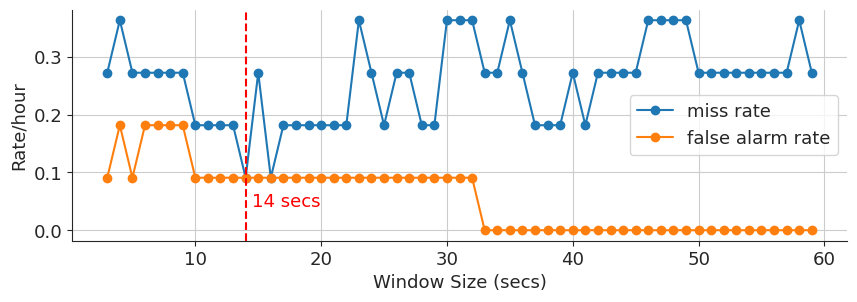

In [69]:
# normalise miss rate, false alarm rate and delay
# window_df['miss rate norm'] = window_df['miss rate'] / window_df['miss rate'].max()
# window_df['false alarm rate norm'] = window_df['false alarm rate'] / window_df['false alarm rate'].max()
window_df.plot(x='window_size', y=['miss rate', 'false alarm rate'],
					  kind='line', marker='o', figsize=(10, 3), grid=True)
# # draw a vertical line and annotate where miss rate norm == delay norm
plt.axvline(14, color='r', linestyle='--')
plt.annotate(f'14 secs', (14.5, 0.04), color='r')
plt.xlabel('Window Size (secs)')
plt.ylabel('Rate/hour')
plt.legend()
sns.despine()
plt.savefig('figs/window_analysis.pdf', dpi=400, bbox_inches='tight')
plt.show()